<a href="https://colab.research.google.com/github/sunkanmi8243/project-988/blob/main/Project988MultiClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%cd /content/

/content


## Data preprocessing

### Data download
Roboflow was used to label and prepare the data

In [ ]:
#importing dataset from roboflow
!curl -L "https://app.roboflow.com/ds/HgM5h5foYB?key=TFpwVF3LQz" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_005_jpg.rf.0935220fde07b8710d58f4a426599d4d.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_006_jpg.rf.1eca8cc60e4604653eaeeea4ed63ea3d.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_006_jpg.rf.5a51f771137b6232080f2538e322a80d.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_007_jpg.rf.5c6d2ebbd4b5e1a70811945324e26fdc.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_009_jpg.rf.8661857b9c73b1eeb3b9ae83d5df5595.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_010_jpg.rf.d8c01af7b40c7077d78c5c5c379f20cc.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_010_jpg.rf.e9c5dc434d6b53512a44114dfda9fb27.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_011_jpg.rf.7dacd421e0fb0a598f63e23218ba7133.jpg  
 extracting: train/Alpro-Fresh-Soy-Milk/Alpro-Fresh-Soy-Milk_

In [ ]:
#create image folder and move datasets to corresponding /image folders
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

In [ ]:
#Turning dataset into a Tensorflow Dataset format using ImageFolder dataset structure of Tensorflow
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=82),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=542, num_shards=1>,
        'train': <SplitInfo num_examples=3795, num_shards=1>,
        'valid': <SplitInfo num_examples=1085, num_shards=1>,
    },
    citation="""""",
)


Show images and labels from the training set:

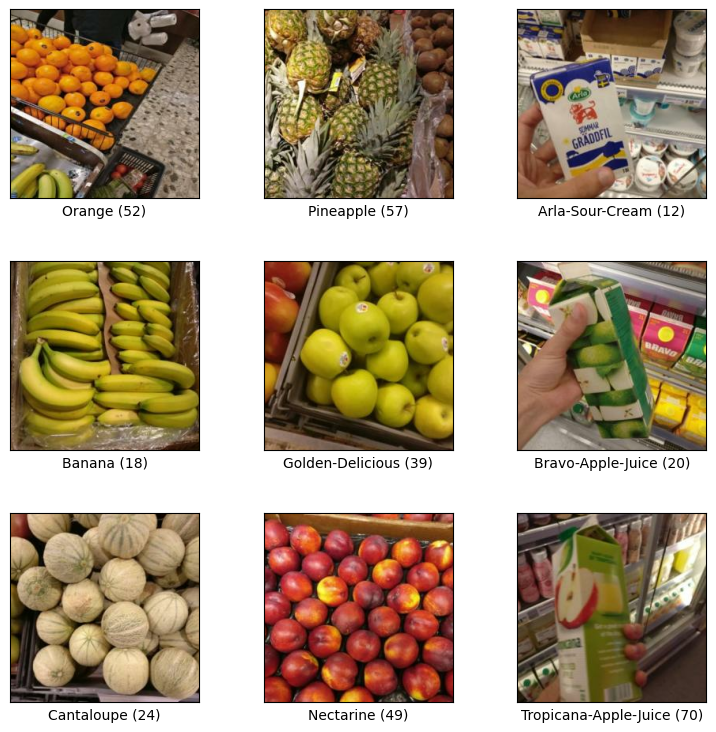

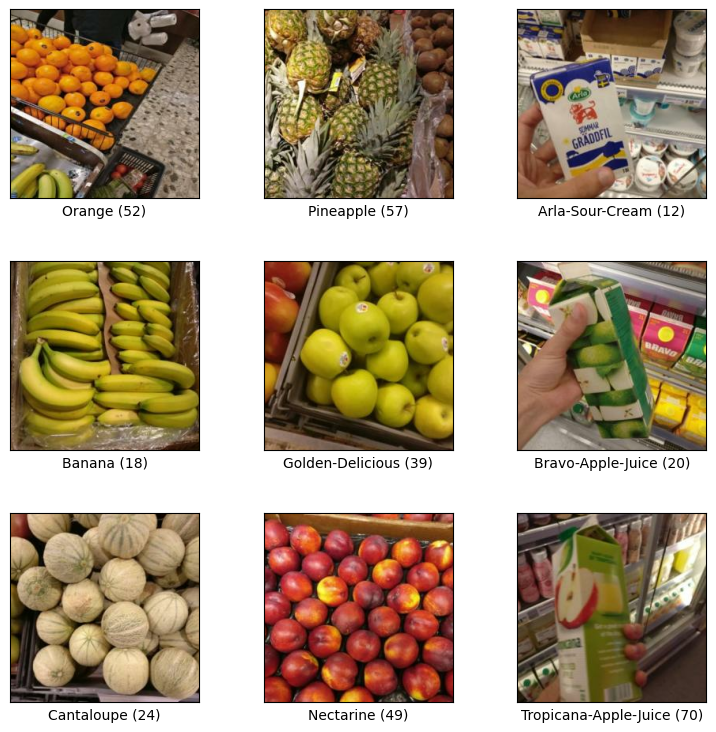

In [ ]:
#just to test. Show images and labels from the training set different images shows up each time
tfds.show_examples(raw_test, builder.info)

In [ ]:
NUM_OF_CLASSES = builder.info.features['label'].num_classes
print('Number of classes:', NUM_OF_CLASSES)

Number of classes: 82


In [ ]:
#let's see the structure of our dataset
def print_dataset_contents(dataset, steps):
    for sample in dataset:
        # Since you're using ImageFolder, each sample is a tuple (image, label)
        image, label = sample['image'], sample['label']
        print("Image shape:", image.shape)
        print("Label:", label.numpy())
        steps = steps - 1
        if steps == 0:
          break



# Print contents of each dataset
print("\nValidation dataset:")
print_dataset_contents(raw_valid, 10)


Validation dataset:
Image shape: (240, 240, 3)
Label: 25
Image shape: (240, 240, 3)
Label: 17
Image shape: (240, 240, 3)
Label: 36
Image shape: (240, 240, 3)
Label: 18
Image shape: (240, 240, 3)
Label: 76
Image shape: (240, 240, 3)
Label: 47
Image shape: (240, 240, 3)
Label: 52
Image shape: (240, 240, 3)
Label: 15
Image shape: (240, 240, 3)
Label: 39
Image shape: (240, 240, 3)
Label: 16


### Format the Data


In [ ]:
#format and normalize the data
IMG_SIZE = 160
def format_data(pair):
  """3 major steps here. First is to use tf.cast to cast image to tf.float32 format
  2. use tf.image.resize to resize image to chosen size"""
  image, label = pair["image"], pair["label"]
  image = tf.cast(image, tf.float32)
  image = (image/127.5) -1.  #this effectively centralizes the data (from range 0-255) giving it a range of [-1, 1]
  #image = (image/255)  #this effectively centralizes the data (from range 0-255) giving it a range of [-1, 1]
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # All images will be resized to 160x160
  label = tf.one_hot(label, depth=NUM_OF_CLASSES)  # Perform one-hot encoding
  return image, label


In [ ]:
#map the function above to each element of the dataset
#note that each element of the dataset (pair) contains image and label in a dictinary
train = raw_train.map(format_data)
validation = raw_valid.map(format_data)
test = raw_test.map(format_data)

In [ ]:
#shuffle and batch the data
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
#shuffle the train_batches and batch. Only shuffle train datasets
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
#Inspecting a batch of data
for image_batch, label_batch in train_batches.take(1):
   pass

print(image_batch.shape)
print(label_batch.shape)
print(label_batch)

(32, 160, 160, 3)
(32, 82)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 82), dtype=float32)


In [ ]:
class_names = builder.info.features['label'].names
class_names

['Alpro-Blueberry-Soyghurt',
 'Alpro-Fresh-Soy-Milk',
 'Alpro-Shelf-Soy-Milk',
 'Alpro-Vanilla-Soyghurt',
 'Anjou',
 'Arla-Ecological-Medium-Fat-Milk',
 'Arla-Ecological-Sour-Cream',
 'Arla-Lactose-Medium-Fat-Milk',
 'Arla-Medium-Fat-Milk',
 'Arla-Mild-Vanilla-Yoghurt',
 'Arla-Natural-Mild-Low-Fat-Yoghurt',
 'Arla-Natural-Yoghurt',
 'Arla-Sour-Cream',
 'Arla-Sour-Milk',
 'Arla-Standard-Milk',
 'Asparagus',
 'Aubergine',
 'Avocado',
 'Banana',
 'Beef-Tomato',
 'Bravo-Apple-Juice',
 'Bravo-Orange-Juice',
 'Brown-Cap-Mushroom',
 'Cabbage',
 'Cantaloupe',
 'Carrots',
 'Coles-Lite-Milk',
 'Conference',
 'Cucumber',
 'Floury-Potato',
 'Galia-Melon',
 'Garant-Ecological-Medium-Fat-Milk',
 'Garant-Ecological-Standard-Milk',
 'Garlic',
 'Ginger',
 'God-Morgon-Apple-Juice',
 'God-Morgon-Orange-Juice',
 'God-Morgon-Orange-Red-Grapefruit-Juice',
 'God-Morgon-Red-Grapefruit-Juice',
 'Golden-Delicious',
 'Granny-Smith',
 'Green-Bell-Pepper',
 'Honeydew-Melon',
 'Kaiser',
 'Kiwi',
 'Leek',
 'Lemon',


In [ ]:
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
print(label_map)

{'Alpro-Blueberry-Soyghurt': 0, 'Alpro-Fresh-Soy-Milk': 1, 'Alpro-Shelf-Soy-Milk': 2, 'Alpro-Vanilla-Soyghurt': 3, 'Anjou': 4, 'Arla-Ecological-Medium-Fat-Milk': 5, 'Arla-Ecological-Sour-Cream': 6, 'Arla-Lactose-Medium-Fat-Milk': 7, 'Arla-Medium-Fat-Milk': 8, 'Arla-Mild-Vanilla-Yoghurt': 9, 'Arla-Natural-Mild-Low-Fat-Yoghurt': 10, 'Arla-Natural-Yoghurt': 11, 'Arla-Sour-Cream': 12, 'Arla-Sour-Milk': 13, 'Arla-Standard-Milk': 14, 'Asparagus': 15, 'Aubergine': 16, 'Avocado': 17, 'Banana': 18, 'Beef-Tomato': 19, 'Bravo-Apple-Juice': 20, 'Bravo-Orange-Juice': 21, 'Brown-Cap-Mushroom': 22, 'Cabbage': 23, 'Cantaloupe': 24, 'Carrots': 25, 'Coles-Lite-Milk': 26, 'Conference': 27, 'Cucumber': 28, 'Floury-Potato': 29, 'Galia-Melon': 30, 'Garant-Ecological-Medium-Fat-Milk': 31, 'Garant-Ecological-Standard-Milk': 32, 'Garlic': 33, 'Ginger': 34, 'God-Morgon-Apple-Juice': 35, 'God-Morgon-Orange-Juice': 36, 'God-Morgon-Orange-Red-Grapefruit-Juice': 37, 'God-Morgon-Red-Grapefruit-Juice': 38, 'Golden-De

In [ ]:
import json
with open('label.txt','w') as f:
  json.dump(label_map, f)

## Create the base model from the convnets


In [ ]:
#instantiate base model excluding the top layer
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from MobileNet V2 for transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
#use base model to extract feature batch from image batch
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
 freeze the convolutional base created from the previous step and to use as a feature extractor

### Freeze the convolutional base

In [ ]:
#freezes the convolutional base
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
#The result of the base model shows that the spacial dimensions keep reducing while the depth (no of channels) increase
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
#create a global average layer and pass the feature batch through it to get the feature batch average (32, 1280)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Instantiate predition layer (dense tins), specify number of nodes and and pass the featuee batch avetge to it
prediction_layer = tf.keras.layers.Dense(NUM_OF_CLASSES, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 82)


In [ ]:
#stack up 2 more layers to the base model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model



In [ ]:
#compilation before trainning
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)
model.compile(optimizer=optimizer,
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 82)                105042    
                                                                 
Total params: 2363026 (9.01 MB)
Trainable params: 105042 (410.32 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
print(model.output_shape)

(None, 82)


In [ ]:
len(model.trainable_variables)

2

### Train the model



In [ ]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


20/20 [==============================] - 4s 44ms/step - loss: 5.0233 - accuracy: 0.0031


In [ ]:
print("initial loss: {:.2f}%".format(loss0*100))
print("initial accuracy: {:.2f}%".format(accuracy0*100))

initial loss: 502.33%
initial accuracy: 0.31%


In [ ]:
#validation gradually improves from an accuracy of 0.8618
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
119/119 [==============================] - 11s 54ms/step - loss: 2.1155 - accuracy: 0.4848 - val_loss: 0.9675 - val_accuracy: 0.7493
Epoch 2/20
119/119 [==============================] - 5s 40ms/step - loss: 0.5899 - accuracy: 0.8804 - val_loss: 0.6140 - val_accuracy: 0.8488
Epoch 3/20
119/119 [==============================] - 5s 36ms/step - loss: 0.3236 - accuracy: 0.9510 - val_loss: 0.5016 - val_accuracy: 0.8645
Epoch 4/20
119/119 [==============================] - 5s 41ms/step - loss: 0.2070 - accuracy: 0.9773 - val_loss: 0.4153 - val_accuracy: 0.8931
Epoch 5/20
119/119 [==============================] - 6s 41ms/step - loss: 0.1492 - accuracy: 0.9837 - val_loss: 0.3778 - val_accuracy: 0.9005
Epoch 6/20
119/119 [==============================] - 5s 37ms/step - loss: 0.1094 - accuracy: 0.9918 - val_loss: 0.3492 - val_accuracy: 0.9088
Epoch 7/20
119/119 [==============================] - 6s 47ms/step - loss: 0.0862 - accuracy: 0.9958 - val_loss: 0.3251 - val_accuracy: 0.908

### Learning curves


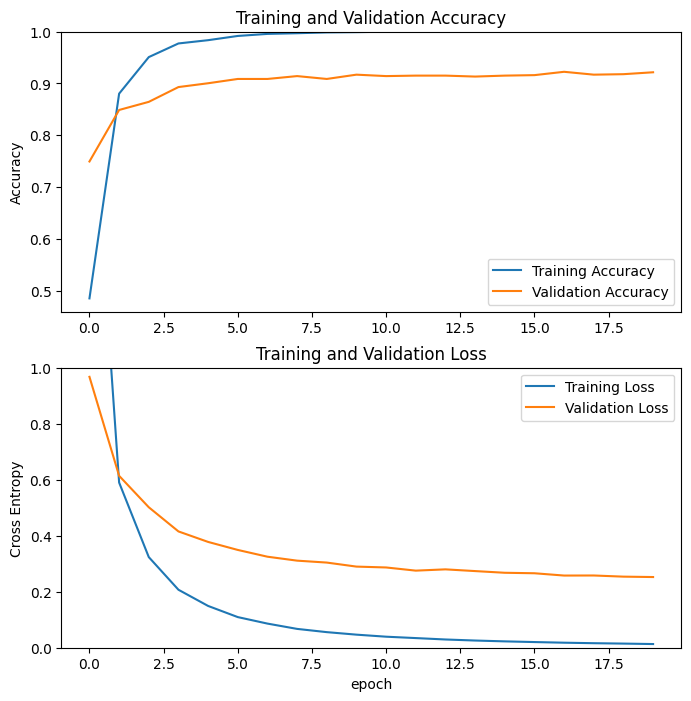

In [ ]:
#Let's take a look at the learning curves of the training and validation accuracy/loss
#when using the MobileNet V2 base model as a fixed feature extractor

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


In [ ]:
#unfreezing top layer of the base model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
#basically freezeing from layer 0 to 100 in the base model
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

Compile the model using a much lower learning rate.

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 82)                105042    
                                                                 
Total params: 2363026 (9.01 MB)
Trainable params: 1966482 (7.50 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

56

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_batches,
                         initial_epoch = history.epoch[-1],
                         epochs=total_epochs,
                         validation_data=validation_batches
                         )

Epoch 20/30
119/119 [==============================] - 20s 60ms/step - loss: 0.4951 - accuracy: 0.8651 - val_loss: 0.9257 - val_accuracy: 0.7465
Epoch 21/30
119/119 [==============================] - 6s 45ms/step - loss: 0.0770 - accuracy: 0.9845 - val_loss: 0.6623 - val_accuracy: 0.7982
Epoch 22/30
119/119 [==============================] - 7s 53ms/step - loss: 0.0401 - accuracy: 0.9942 - val_loss: 0.3523 - val_accuracy: 0.8912
Epoch 23/30
119/119 [==============================] - 6s 49ms/step - loss: 0.0275 - accuracy: 0.9942 - val_loss: 0.3392 - val_accuracy: 0.8986
Epoch 24/30
119/119 [==============================] - 7s 53ms/step - loss: 0.0208 - accuracy: 0.9963 - val_loss: 0.2832 - val_accuracy: 0.9097
Epoch 25/30
119/119 [==============================] - 6s 49ms/step - loss: 0.0127 - accuracy: 0.9984 - val_loss: 0.3762 - val_accuracy: 0.8903
Epoch 26/30
119/119 [==============================] - 6s 49ms/step - loss: 0.0113 - accuracy: 0.9979 - val_loss: 0.3647 - val_accuracy

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

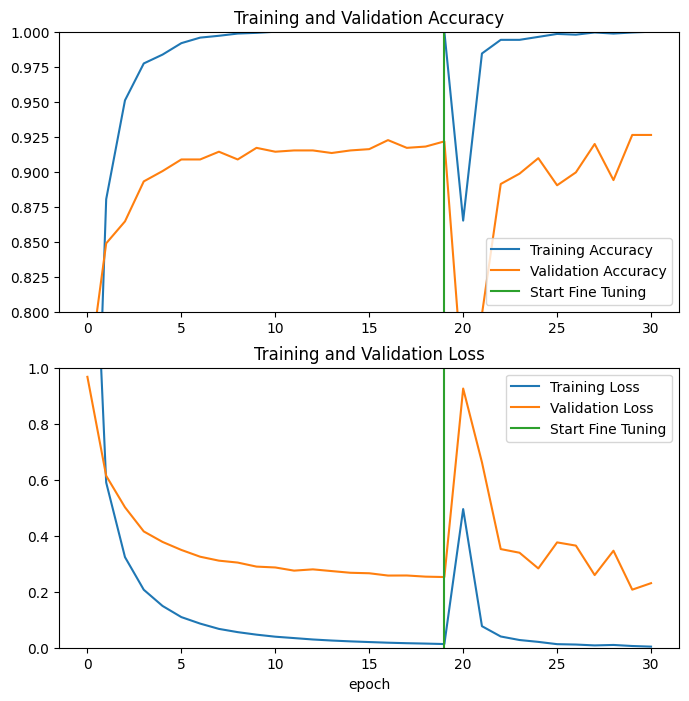

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Infer on a Sample Image

In [ ]:
# Import necessary libraries
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

# Initialize metrics
precision_metric = Precision()
recall_metric = Recall()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_batches)

# Update the metrics with the predictions and true labels
for images, labels in test_batches:
    predictions = model.predict(images)
    precision_metric.update_state(labels, predictions)
    recall_metric.update_state(labels, predictions)

# Calculate and print the precision and recall
precision = precision_metric.result()
recall = recall_metric.result()
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)
print("Test recall:", recall.numpy())
print("Test precision:", precision.numpy())

1/1 [==============================] - 1s 1s/step
Test loss: 0.25353318452835083
Test accuracy: 0.9391143918037415
Test recall: 0.92250925
Test precision: 0.9487666


In [ ]:
import tensorflow as tf

# Example: Save a Keras model
#model = tf.keras.Sequential([...])  # Your Keras model
saved_model_dir = 'saved_model'
tf.saved_model.save(model, saved_model_dir)

In [ ]:

# Convert the model to tflite
saved_model_dir = 'saved_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT] #quantization
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)